In [12]:
from scipy.integrate import quad as integrate, trapz 
from scipy import interpolate
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("nbagg")   #подключить эти пакеты для анимации 

In [13]:
lq = 3
Num = 100_000 # количество генерируемых точек
hxi = 0.01*np.pi # шаг генерации
beta = 0.0276 # температурный делитель
l = 2*np.pi # область генерации начального распределения
n = int(l/hxi)
# в зависимости от phix (0 или pi) надо будет менять область построения
phix = np.pi # 0 

# Блок начального распределения состояний
### вычисляем статсумму. не берем интеграл по бесконечному интервалу, потому что функция слишком быстhро стремится к нулю, а встроенные методы пренебрегают пиком в центре интервала

In [14]:
LL = 10*np.pi # интервал, на котором производится интегрирование
X = np.linspace(-LL/2, LL/2, 10_000)

def fun(x): # функция распределения
    return np.exp((np.cos(x)-1)/beta)*np.exp(-((x-phix)**2)/(2*lq*beta))
part_func = trapz(fun(X), X)
# print('Статсумма = ', part_func, 'в математике получили 6.39276*10^-20 при phix = Pi')

In [15]:
def U(x): 
    return (x-phix)**2/(2*lq) + 1 - np.cos(x)

def coor_destr(x):
    return np.exp(-U(x)/beta)/part_func

xi = np.linspace(-np.pi + phix, np.pi + phix, n)
# применяем определение функции распределения
def prob(xx):
    return integrate(lambda phi: coor_destr(phi), -np.inf, xx)[0]

![title](bKMhV5v3mXk.jpg)

In [16]:
alpha = []
for xx in xi:
    alpha.append(prob(xx))

inter_func = interpolate.interp1d(alpha, xi)

plt.plot(alpha, inter_func(alpha))
plt.title('Обратная функция распределения')
plt.xlabel('F(x)')
plt.ylabel('x')
plt.show()
# Функция распределения - вероятность того, что случайная величина X примет значение, 
# меньшее или равное х, где х — произвольное действительное число

In [17]:
np.random.seed(1997)
random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
phi_points = inter_func(random_points) # значения phi c требуемым распределением
p_points = np.random.normal(0, np.sqrt(beta), Num)
# применяем свойство независимости распределений
#all_points = np.column_stack((phi_points, p_points))

<IPython.core.display.Javascript object>


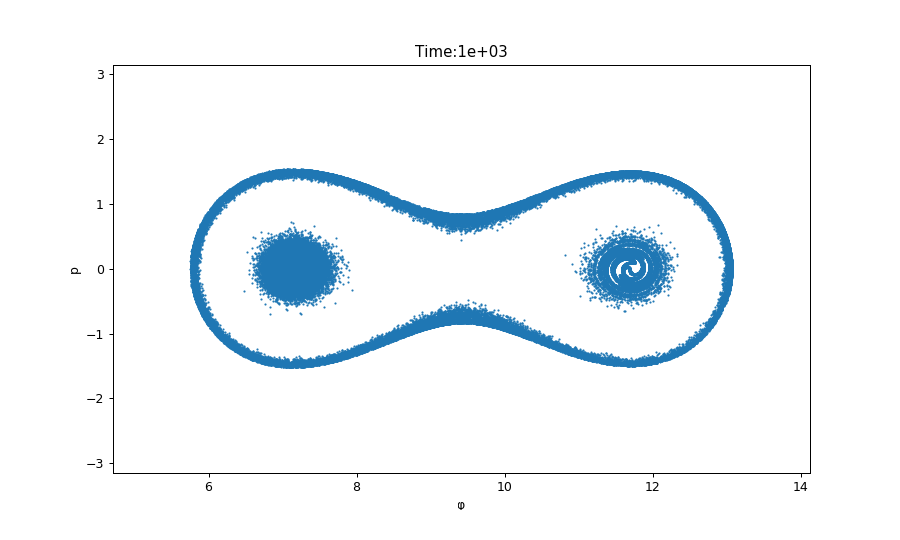

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(phi_points, p_points, s = 0.5) # s - размер точек
plt.xlim(-1.5*np.pi+phix, 1.5*np.pi+phix)
plt.ylim(-np.pi, np.pi)
plt.title('Начальное распределение')
plt.ion()   # set interective mode
plt.show()

In [20]:
# тест на количество точек при двухямном потенциале (ожидается одинаковое)
left_points = len(list(filter(lambda x: x < np.pi, phi_points)))
right_points = len(list(filter(lambda x: x > np.pi, phi_points)))
print('В левой яме {} состояний, в правой - {}. Их соотношение: {}'.format(left_points, right_points, right_points/left_points))

В левой яме 49885 состояний, в правой - 50115. Их соотношение: 1.0046106043900973


# Блок динамики во времени

In [21]:
gamma = 0. # коэффициент затухания
tau = 1000 # характерное время переключения
T = 1010 # полный интервал времени
dt = 0.1 # шаг по времени
t = np.linspace(0,T, int(T/dt))


In [22]:
def phixx(t): # функция именения параметра управления
    return np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1) 
    
def H(t, phi, p):
    return p**2/2 + (phi-phixx(t))**2/(2*lq) + 1 - np.cos(phi)

def F(t, phi, p):
    return p, -np.sin(phi) - (phi - phix - np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1))/lq - gamma*p

In [23]:
plot_iter = 0
for it in t:
    plot_iter += 1
    plt.clf()
    k1 = F(it, phi_points, p_points)
    k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
    k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
    k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
    phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
    p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
     
    if plot_iter%100 == 0:
        # Установка отображаемых интервалов по осям
        plt.scatter(phi_points, p_points, s = 0.5) # s - размер точек
        plt.xlim(-0.5*np.pi+phixx(it), 2.5*np.pi+phixx(it))
        plt.ylim(-np.pi, np.pi)
        plt.title("Time:{:.1}".format(it))
        plt.savefig('anim/best_gif{}.png'.format(plot_iter)) # сохраняет картинки для анимации
        plt.xlabel('φ')
        plt.ylabel('p')
        plt.gcf().canvas.draw()

## 1. Зависимости среднего значения разности фаз и ее стандартного отклонения на всем промежутке времени для разных значений затухания и фиксированного значения времени переключения. 
### Ожидание: показать как влияе затухание на "определенность" тока

 

## 2. Зависимость среднего значения разности фаз и его дисперсии (разброса) в после переключения (tau + 10). 
### Ожидание: получить адиабатическое время перекллючения. Ожидается, что после некоторого tau для случая без затухания дисперсия менятся уже не будет.

## 3. Зависимость разности фаз (средней, например) от времени при разных значениях начального возмущения (вышее мы считали его нулевым)
### Ожидание: показать чувствительность зависимости от начального состояния